In [1]:
import pickle as pkl

import lxml
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.datasets import imdb


from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add
from tensorflow.keras.initializers import glorot_uniform
#from tensorflow.keras.utils.vis_utils import plot_model

import importlib

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; ) </style>}"))
#importlib.reload(tensorflow)

/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

## Helper Functions

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    NOTE: Taken from sklearn example
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    
    #ax.figsize((10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    ax.plot()
    fig.tight_layout()
    fig.show()
    #return ax

In [3]:
from IPython.display import clear_output
class PlotLosses(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        plt.clf()
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
        plt.plot(range(len(global_history)), global_history, label = 'Accuracy - Global')
        plt.plot(range(len(global_val_history)), global_val_history, label = 'Accuracy - Global - Va;')
        
        #print(np.where(np.array(train_gene_change_list) == True))
        

        #plt.vlines(np.where(np.array(train_gene_change_list) == True), ymin = 0,
        #                               ymax = 1)
        
            #np.where(test_gene_change_list == True]

        
        plt.legend()
        plt.show()
        
        plt.hist(Y_val_predictions, label = 'Prediction Distribution')
        plt.legend()
        plt.show()    
        
        plt.hist(Y_val_actual, label = 'Actual Distribution')
        plt.legend()
        plt.show()
        
        plt.plot(global_f1_scores)
        plt.ylabel('F1 Score')
        plt.ylabel('epochs * train data')
        plt.show()
        
        Y_val_predictions_binary = [1 if (i > 0.5) else 0 for i in Y_val_predictions ]
        cm = confusion_matrix(np.array(Y_val_actual).ravel(), Y_val_predictions_binary)    
        classes = [0,1]
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        print(cm)
        #if (len(predictions) > 2) & (len(Y_val_actual) > 2):
        #    plot_confusion_matrix(np.array(Y_val_actual).ravel(), Y_val_predictions, classes=[0, 1], normalize=True,
        #              title='Normalized confusion matrix')
        #else:
        #    pass
        
plot_losses = PlotLosses()

In [4]:
tqdm.pandas()

In [33]:
import tensorflow as tf
with tf.Session() as sess:
    devices = sess.list_devices()

In [6]:
import sys

In [7]:
!{sys.executable} -m list

/miniconda/bin/python: No module named list


## Reading the Data

In [6]:
iterator = True


if iterator == True:
    
    drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 7500, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                         lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                        "drug_fingerprint_encoded_padded": \
                                                                                        lambda x: np.array(x.strip("[]").replace("'","").split(", "))})
if iterator == False:

    drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', converters={"target_gene_encoded_padded": \
                                                                                         lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                        "drug_fingerprint_encoded_padded": \
                                                                                        lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

## CNN in Chunks

In [58]:

#drugbank = drugbank_reader.__next__()


In [37]:
drugbank

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
16500,DB01284,BE0003634,2246728737 3537119515 2245273601 3004333805 22...,ATGTTGTTCTCCGCCCTCCTGCTGGAGGTGATTTGGATCCTGGCTG...,0,[0 3 2 ... 3 0 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...",1014,4039,-3025,20208,5462,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16501,DB05327,BE0008691,2968968094 1910766508 3217380708 3234104871 86...,ATGGGGGGCTCGGGCAGTCGCCTGTCCAAGGAGCTGCTGGCCGAGT...,0,[0 3 2 2 2 2 2 2 1 3 1 2 2 2 1 0 2 3 1 2 1 1 3...,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 1, 9, 1, 0, 7, ...",576,498,78,20646,9003,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16502,DB06932,BE0002622,2246728737 422715066 3217380708 3120642300 321...,ATGGAACAACAACCATTAACATTAACGGCGGCGACAACTCGTGCGC...,0,[0 3 2 ... 3 0 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",2031,491,1540,19191,9010,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16503,DB01766,BE0000048,3218693969 98513984 3218693969 98513984 321869...,ATGGCGCACGTCCGAGGCTTGCAGCTGCCTGGCTGCCTGGCCCTGG...,1,[0 3 2 ... 3 0 2],"[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 8, 5, 1, 3, ...",1869,306,1563,19353,9195,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16504,DB05327,BE0001814,2968968094 1910766508 3217380708 3234104871 86...,ATGCCATCACTCAGTAAAGAAGCGGCCCTGGTTCATGAAGCGTTAG...,0,[0 3 2 1 1 0 3 1 0 1 3 1 0 2 3 0 0 0 2 0 0 2 1...,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 1, 9, 1, 0, 7, ...",669,498,171,20553,9003,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,DB02484,BE0003635,3218693969 951226070 3218693969 571978829 2092...,ATGGGGAGGCTGCTGGCCTTAGTGGTCGGCGCGGCACTGGTGTCCT...,0,[0 3 2 2 2 2 0 2 2 1 3 2 1 3 2 2 1 1 3 3 0 2 3...,"[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 5, 1, 2, 2, ...",657,574,83,20565,8927,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16996,DB02259,BE0001927,2246728737 3542456614 2245384272 618671879 321...,ATGGAAACCTATGCTGTTTTTGGTAATCCGATAGCCCACAGCAAAT...,0,[0 3 2 2 0 0 0 1 1 3 0 3 2 1 3 2 3 3 3 3 3 2 2...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",819,696,123,20403,8805,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16997,DB06855,BE0001739,2246728737 3537119515 2245273601 2423543607 22...,ATGAATCCACTCCTGATCCTTACCTTTGTGGCAGCTGCTCTTGCTG...,1,[0 3 2 0 0 3 1 1 0 1 3 1 1 3 2 0 3 1 1 3 3 0 1...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...",744,487,257,20478,9014,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
16998,DB06201,BE0003790,3218693969 98513984 3218693969 951226070 32173...,ATGAGCAGAAGCAAGCGTGACAACAATTTTTATAGTGTAGAGATTG...,0,[0 3 2 ... 3 2 0],"[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 8, 5, 1, 3, ...",1284,330,954,19938,9171,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [5]:
def identity_block(X, f, filters):
    
    # Number Of Filters For Each Block 
    F1, F2, F3 = filters
    
    # Save Input For Shortcut
    X_shortcut = X
    
    # Component 1
    X = Conv1D(filters = F1, kernel_size = 16, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 2 
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 3 
    X = Conv1D(filters = F3, kernel_size = 16, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    
    # Add Shortcut Path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    

In [6]:
def convolutional_block(X, f, filters, s = 2):
    
    # Number Of Filters For Each Block 
    F1, F2, F3 = filters
    
    # Save Input For Shortcut
    X_shortcut = X
    
    ## Main Path 
    print ("X In Conv : " + str(X.shape))
    # Component 1 
    X = Conv1D(filters = F1, kernel_size = 16, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    print ("Component 1 : " + str(X.shape))
    
    # Component 2
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    print ("Component 2 : " + str(X.shape))
    
    # Component 3
    X = Conv1D(filters = F3, kernel_size = 16, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    print ("Component 3 : " + str(X.shape))
    
    ## Shortcut Path
    X_shortcut = Conv1D(filters = F3, kernel_size = 16, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    print ("X Shortcut : " + str(X_shortcut.shape))
    
    # Add Shortcut Path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [7]:
def ResNet_1D(input_shape = (30723, 1)):
    
    X_input = Input(input_shape)
    
    # Stage 1
    print ("X Input : " + str(X_input.shape))
    X = Conv1D(filters = 64, kernel_size = 16, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform())(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    print ("X : " + str(X.shape))
    
    # Stage 2 - 1 Conv Block & 2 Identity Blocks
    X = convolutional_block(X, f = 48, filters = [64, 64, 128], s = 1)
    X = identity_block(X, f = 48, filters = [64, 64, 128])
    X = identity_block(X, f = 48, filters = [64, 64, 128])
    
    # Stage 3 - 1 Conv Block & 3 Identity Blocks
    X = convolutional_block(X, f = 16, filters = [128, 128, 256])
    X = identity_block(X, f = 48, filters = [128, 128, 256])
    X = identity_block(X, f = 48, filters = [128, 128, 256])
    X = identity_block(X, f = 48, filters = [128, 128, 256])
    
    # Stage 4 - 1 Conv Block & 5 Identity Blocks
    X = convolutional_block(X, f = 32, filters = [256, 256, 512])
    X = identity_block(X, f = 48, filters = [256, 256, 512])
    X = identity_block(X, f = 48, filters = [256, 256, 512])
    X = identity_block(X, f = 48, filters = [256, 256, 512])
    X = identity_block(X, f = 48, filters = [256, 256, 512])
    X = identity_block(X, f = 48, filters = [256, 256, 512])
    
    # Stage 5 - 1 Conv Block & 2 Identity Blocks 
    X = convolutional_block(X, f = 48, filters = [512, 512, 1024])
    X = identity_block(X, f = 48, filters = [512, 512, 1024])
    X = identity_block(X, f = 48, filters = [512, 512, 1024])
    
    
    X = GlobalAveragePooling1D()(X)
    X = Flatten()(X)
    X = Dense(1, kernel_initializer = glorot_uniform())(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model
    

In [80]:
def VGG_16():

    #X_input = Input(input_shape)
    
    genes_input = Input(shape=(21222,1))
    drugs_input = Input(shape=(9501,1))

    
    # Convolution Block 1
    X_0 = Conv1D(filters = 612, kernel_size = 8, strides = 2, activation = 'relu')(genes_input)
    X_1 = Conv1D(filters = 356, kernel_size = 8, strides = 2, activation = 'relu')(drugs_input)
    
    X_0 = Dropout(0.3)(X_0)
    X_1 = Dropout(0.3)(X_1)
    
    X_0 = Conv1D(filters = 256, kernel_size = 8, strides = 2, activation = 'relu')(X_0)
    X_1 = Conv1D(filters = 128, kernel_size = 8, strides = 2, activation = 'relu')(X_1)

    X_0 = BatchNormalization()(X_0)
    X_1 = BatchNormalization()(X_1)
    
    X = AveragePooling1D()(X_0)
    X = AveragePooling1D()(X_1)
    
    
    # Convolution Block 2
    X_0 = Conv1D(filters = 64, kernel_size = 8, strides = 2, activation = 'relu')(X_0)
    X_1 = Conv1D(filters = 32, kernel_size = 8, strides = 2, activation = 'relu')(X_1)
    
    X_0 = Conv1D(filters = 64, kernel_size = 8, strides = 2, activation = 'relu')(X_0)
    X_1 = Conv1D(filters = 32, kernel_size = 8, strides = 2, activation = 'relu')(X_1)
    
    X_0 = BatchNormalization()(X_0)
    X_1 = BatchNormalization()(X_1)
    
    # Test Drop Out


    # Convolution Block 3
    X_0 = Conv1D(filters = 32, kernel_size = 2, strides = 2, activation = 'relu')(X_0)
    #X_0 = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X_0)
    #X_0 = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X_0)
    #X_0 = BatchNormalization()(X_0)
    
    X_1 = Conv1D(filters = 32, kernel_size = 2, strides = 2, activation = 'relu')(X_1)
    #X_1 = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X_1)
    #X_1 = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X_1)
    #X_1 = BatchNormalization()(X_1)
    
        
    X_0 = Flatten()(X_0)
    X_1 = Flatten()(X_1)
    combined = Concatenate(axis=-1)([X_0, X_1])


    # Test Drop Out
    X = Dropout(0.3)(combined)
    #X_0 = Dropout(0.4)(X_0)
    #X_1 = Dropout(0.4)(X_1)

    # Convolution Block 4
    #X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = BatchNormalization()(X)
    # Test Drop Out
    # X = Dropout(0.7)(X)

    # Convolution Block 5
    #X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = BatchNormalization()(X)
    
    
    #X = GlobalAveragePooling1D()(X)
    #X = Dense(256, kernel_initializer = glorot_uniform())(X)
    
    
    #X_0 = GlobalAveragePooling1D()(X_0)
    #X_0 = Dense(256, kernel_initializer = glorot_uniform())(X_0)
    
    #X_1 = GlobalAveragePooling1D()(X_1)
    #X_1 = Dense(256, kernel_initializer = glorot_uniform())(X_1)

    #X = Dense(128, kernel_initializer = glorot_uniform())(X)
    X = Dense(48, kernel_initializer = glorot_uniform())(X)
    X = Dense(1, kernel_initializer = glorot_uniform())(X)
    
    X = Activation('sigmoid')(X)

    model = Model(inputs = [drugs_input,genes_input] , outputs = X)

    return model

In [81]:
model = VGG_16()

In [82]:
# model = ResNet_1D()

In [83]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 21222, 1)     0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 9501, 1)      0                                            
__________________________________________________________________________________________________
conv1d_90 (Conv1D)              (None, 10608, 612)   5508        input_19[0][0]                   
__________________________________________________________________________________________________
conv1d_91 (Conv1D)              (None, 4747, 356)    3204        input_20[0][0]                   
__________________________________________________________________________________________________
dropout_27

In [88]:
model_optimizer = tensorflow.keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
hidden_dims_3 = 32
batch_size = 10
epochs = 2
trim_width = 0

class_weight = {0: 1,
                1: 1}

In [85]:
model.compile(loss = 'binary_crossentropy', optimizer = model_optimizer, metrics = ['binary_accuracy'])

In [52]:
#Uncomment to read model
#model = tensorflow.keras.models.load_model('../data/models/CNN_GPU_VGG_Multi_Channel_0.model')

In [15]:
%%time

#drugbank = pd.read_csv('../data/intermediate/interactions_preprocessed.csv', chunksize = 500, iterator = True, converters={"target_gene_encoded_padded": \
#                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
#                                                                                    "drug_fingerprint_encoded_padded": \
#                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})


drugbank = pd.read_csv('../data/intermediate/interactions_preprocessed_OG.csv', iterator = False, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})


CPU times: user 7min 40s, sys: 9.59 s, total: 7min 49s
Wall time: 7min 50s


In [90]:
drugbank = drugbank.sort_values(['gene_id', 'Y'], ascending = False)
drugbank_reader = np.array_split(drugbank, len(drugbank)/500)

In [42]:
len(drugbank)

46918

In [43]:
#len(drugbank_test['drug_fingerprint_encoded_padded'][0])

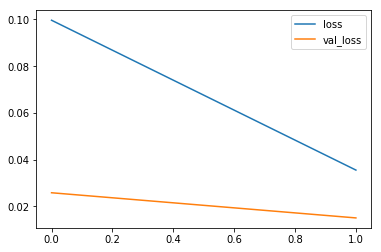

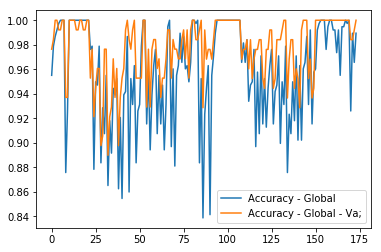

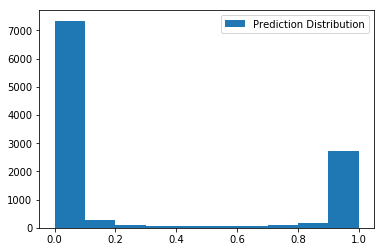

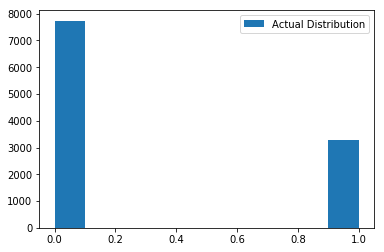

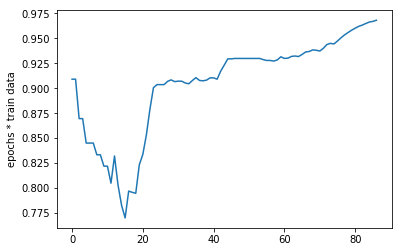

[[0.99483071 0.00516929]
 [0.05022971 0.94977029]]
 - 10s - loss: 0.0355 - binary_accuracy: 0.9894 - val_loss: 0.0151 - val_binary_accuracy: 0.9921



In [91]:
global_history = []
global_val_history = []
Y_val_predictions = []
Y_val_actual = []
Y_actual = []
global_f1_scores = []

train_gene_change_list = []
test_gene_change_list = []

with open('../data/gene_encoder.pkl', 'rb') as f:
    label_encoder = pkl.load(f)
    

for drugbank_i in tqdm(drugbank_reader[5:]):
    
    
    print('Reading chunk from file..')
    #drugbank = drugbank_reader.__next__()
    
    #drugbank['target_gene_encoded'] = drugbank['target_gene_code'].progress_apply(\
    #                                   lambda x: label_encoder.transform([i for i in list(x) if i in gene_chars]))
    #drugbank['drug_fingerprint_encoded'] = drugbank['drug_fingerprint_code'].progress_apply(lambda x: [int(i) for i in x.replace(' ', '')])

    #drugbank['Y'].apply(lambda x: -1 if x == 0 else x) #use for tanh activation
    
    print('Sampling..')
    train_df_inter, test_df = train_test_split(drugbank_i)

    ##FORCE TRAIN NEGATIVE SAMPLES ON LOW EPOCH
    train_df = pd.DataFrame()
    
    if len(train_df_inter[train_df_inter['Y'] == 0]) > 2:
        train_df = train_df.append(train_df_inter[train_df_inter['Y'] == 0].sample(frac = 1.0))
    
    if len(train_df_inter[train_df_inter['Y'] == 1]) > 2:
        train_df = train_df.append(train_df_inter[train_df_inter['Y'] == 1].sample(frac = 1.0))


    
    print('Padding..') 
    X_0 = np.array(list(train_df['target_gene_encoded_padded']))
    X_1 = np.array(list(train_df['drug_fingerprint_encoded_padded']))
    Y   = np.array(list(train_df['Y']))
    

    X_0_test = np.array(list(test_df['target_gene_encoded_padded']))
    X_1_test = np.array(list(test_df['drug_fingerprint_encoded_padded']))
        
    Y_test   = np.array(list(test_df['Y']))
    
    print(X_0.shape)
    print(X_1.shape)
    
    print(X_0_test.shape)
    print(X_1_test.shape)

    print('Trimming..')
    X_0 = X_0[:, int(trim_width/2) : X_0.shape[1] - int(trim_width/2)]
    X_1 = X_1[:, int(trim_width/2) : X_1.shape[1] - int(trim_width/2)]
    
    X_0_test = X_0_test[:, int(trim_width/2) : X_0_test.shape[1] - int(trim_width/2)]
    X_1_test = X_1_test[:, int(trim_width/2) : X_1_test.shape[1] - int(trim_width/2)]
    

    X_0 = X_0.astype(int) + 1
    X_1 = X_1.astype(int) + 1
    Y   = Y.astype(int)

    X_0_test = X_0_test.astype(int) + 1
    X_1_test = X_1_test.astype(int) + 1
    Y_test   = Y_test.astype(int)
    
    print(X_0.shape)
    print(X_1.shape)
    
    print(X_0_test.shape)
    print(X_1_test.shape)


    #X_0 = np.hstack((X_0, X_1))
    #X_0_test = np.hstack((X_0_test, X_1_test))

    print('Modelling..')
    
    print("X0 Shape : " + str(X_0.shape))
    print("X1 Shape : " + str(X_1.shape))
    
    print("X0 Test Shape : " + str(X_0_test.shape))
    print("X1 Test Shape : " + str(X_1_test.shape))
    
    
    history = model.fit([X_1[..., np.newaxis],X_0[..., np.newaxis]], Y,
                          batch_size=batch_size,
                          epochs=epochs,
                          class_weight = class_weight,
                          callbacks=[plot_losses],
                          validation_data=([X_1_test[..., np.newaxis],X_0_test[..., np.newaxis]], Y_test), verbose = 2)


    Y_actual.extend(Y.tolist())
    
    Y_val_predictions.extend(model.predict([X_1_test[..., np.newaxis],X_0_test[..., np.newaxis]]).ravel())
    Y_val_actual.extend(Y_test.tolist())

    global_val_history.extend(history.history['val_binary_accuracy'])
    global_history.extend(history.history['binary_accuracy'])
    
    global_f1_scores.append(f1_score(np.array(Y_val_actual).ravel(), [1  if (i > 0.5) else 0 for i in Y_val_predictions]))

    

In [ ]:
np.array(Y_val_actual).ravel()

In [98]:
len(Y_val_predictions)

5333

In [26]:
np.where(np.array(train_gene_change_list) == True)

(array([], dtype=int64),)

In [ ]:
np.array(Y_actual).shape

In [92]:
model.save('../data/models/CNN_GPU_VGG_Multi_Channel_wide.model')